# EnvironmentCluster
The `freud.environment.EnvironmentCluster` class finds and clusters local environments, as determined by the vectors pointing to neighbor particles. Neighbors can be defined by a cutoff distance or a number of nearest-neighbors, and the resulting `freud.locality.NeighborList` is used to enumerate a set of vectors, defining an "environment." These environments are compared with the environments of neighboring particles to form spatial clusters, which usually correspond to grains, droplets, or crystalline domains of a system. `EnvironmentCluster` has several parameters that alter its behavior, please see the documentation or helper functions below for descriptions of these parameters.

In this example, we cluster the local environments of hexagons. Clusters with 5 or fewer particles are colored dark gray.

*Simulation data courtesy of Shannon Moran, sample code courtesy of Erin Teich.*

In [1]:
import numpy as np
import freud
from collections import Counter
import matplotlib.pyplot as plt
from util import box_2d_to_points

def get_cluster_arr(system, num_neighbors, threshold,
                    registration=False, global_search=False):
    """Computes clusters of particles' local environments.
    
    Args:
        system:
            Any object that is a valid argument to
            :class:`freud.locality.NeighborQuery.from_system`.
        num_neighbors (int):
            Number of neighbors to consider in every particle's local environment.
        threshold (float):
            Maximum magnitude of the vector difference between two vectors,
            below which we call them matching.
        global_search (bool):
            If True, do an exhaustive search wherein the environments of
            every single pair of particles in the simulation are compared.
            If False, only compare the environments of neighboring particles.
        registration (bool):
            Controls whether we first use brute force registration to
            orient the second set of vectors such that it minimizes the
            RMSD between the two sets.

    Returns:
        tuple(np.ndarray, dict): array of cluster indices for every particle
        and a dictionary mapping from cluster_index keys to vector_array)
        pairs giving all vectors associated with each environment.
    """
    # Perform the env-matching calcuation
    neighbors = {'num_neighbors': num_neighbors}
    match = freud.environment.EnvironmentCluster()
    match.compute(system, threshold, neighbors=neighbors,
                  registration=registration, global_search=global_search)
    return match.cluster_idx, match.cluster_environments

def color_by_clust(cluster_index_arr, no_color_thresh=1,
                   no_color='#333333', cmap=plt.get_cmap('viridis')):
    """Takes a cluster_index_array for every particle and returns a
    dictionary of (cluster index, hexcolor) color pairs.
    
    Args:
        cluster_index_arr (numpy.ndarray):
            The array of cluster indices, one per particle.
        no_color_thresh (int):
            Clusters with this number of particles or fewer will be
            colored with no_color.
        no_color (color):
            What we color particles whose cluster size is below no_color_thresh.
        cmap (color map):
            The color map we use to color all particles whose
            cluster size is above no_color_thresh.
    """
    # Count to find most common clusters
    cluster_counts = Counter(cluster_index_arr)
    # Re-label the cluster indices by size
    color_count = 0
    color_dict = {cluster[0]: counter for cluster, counter in
                  zip(cluster_counts.most_common(),
                      range(len(cluster_counts)))}

    # Don't show colors for clusters below the threshold
    for cluster_id in cluster_counts:
        if cluster_counts[cluster_id] <= no_color_thresh:
            color_dict[cluster_id] = -1
    OP_arr = np.linspace(0.0, 1.0, max(color_dict.values())+1)

    # Get hex colors for all clusters of size greater than no_color_thresh
    for old_cluster_index, new_cluster_index in color_dict.items():
        if new_cluster_index == -1:
            color_dict[old_cluster_index] = no_color
        else:
            color_dict[old_cluster_index] = cmap(OP_arr[new_cluster_index])

    return color_dict

We load the simulation data and call the analysis functions defined above. Notice that we use 6 nearest neighbors, since our system is made of hexagons that tend to cluster with 6 neighbors.

In [2]:
ex_data = np.load('data/MatchEnv_Hexagons.npz')
box = ex_data['box']
positions = ex_data['positions']
orientations = ex_data['orientations']

cluster_index_arr, cluster_envs = get_cluster_arr(
    (box, positions), num_neighbors=6, threshold=0.2,
    registration=False, global_search=False)
color_dict = color_by_clust(cluster_index_arr, no_color_thresh=5)
colors = [color_dict[i] for i in cluster_index_arr]

Below, we plot the resulting clusters. The colors correspond to the cluster size.

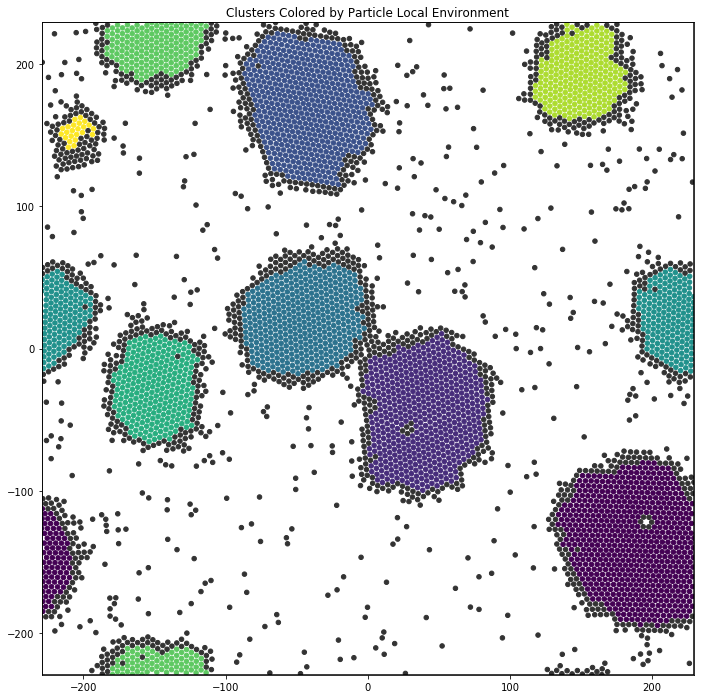

In [3]:
plt.figure(figsize=(12, 12), facecolor='white')
box_points = box_2d_to_points(freud.box.Box.from_box(box))
plt.plot(box_points[:, 0], box_points[:, 1], c='black')
plt.scatter(positions[:, 0], positions[:, 1], c=colors, s=20)
ax = plt.gca()
ax.set_xlim((min(box_points[:, 0]), max(box_points[:, 0])))
ax.set_ylim((min(box_points[:, 1]), max(box_points[:, 1])))
ax.set_aspect('equal')
plt.title('Clusters Colored by Particle Local Environment')
plt.show()